# Practice PS07: Outlier analysis

Author: <font color="blue">Luca Franceschi</font>

E-mail: <font color="blue">luca.franceschi01@estudiant.upf.edu</font>

Date: <font color="blue">4/12/2024</font>

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import io
import random
import numpy as np

# 1. Dataset

In [117]:
# LEAVE AS-IS

df = pd.read_csv('annthyroid.csv', sep=',')

# Replace the "label" column by an "abnormal" column
df['result'] = df['label'].apply(lambda x: 'abnormal' if x == 1 else 'normal')
df.drop(columns=['label'], inplace=True)

<font size="+1" color="red">Replace this cell with your code to print the number and percentages of patients in each group.</font>

In [118]:
df_summary = df.groupby('result').count()
total_patients = df_summary['f1'].sum()

print(f'Total patients: {total_patients}')
print(
    f'Normal thyroid: {df_summary['f1']['normal']} ({df_summary['f1']['normal']/total_patients:.2%})'
)
print(
    f'Abnormal thyroid: {df_summary['f1']['abnormal']} ({df_summary['f1']['abnormal']/total_patients:.2%})'
)

Total patients: 7200
Normal thyroid: 6666 (92.58%)
Abnormal thyroid: 534 (7.42%)


<font size="+1" color="red">Replace this cell with your code to print the first 10 normal exams and the centroid of all normal exams, and the first 10 abnormal exams and the centroid of all abnormal exams.</font>

In [119]:
df_summary = df.groupby('result').mean()
display(df[df['result'] == 'normal'].head(10))
display(df[df['result'] == 'abnormal'].head(10))
display(df_summary)

,f1,f2,f3,f4,f5,f6,result
0,0.73,0.00060,0.015,0.120,0.082,0.146,normal
1,0.24,0.00025,0.030,0.143,0.133,0.108,normal
2,0.47,0.00190,0.024,0.102,0.131,0.078,normal
3,0.64,0.00090,0.017,0.077,0.090,0.085,normal
4,0.23,0.00025,0.026,0.139,0.090,0.153,normal
5,0.69,0.00025,0.016,0.086,0.070,0.123,normal
6,0.85,0.00025,0.023,0.128,0.104,0.121,normal
7,0.48,0.00208,0.020,0.086,0.078,0.110,normal
8,0.67,0.00130,0.024,0.087,0.109,0.080,normal
9,0.76,0.00010,0.029,0.124,0.128,0.097,normal


,f1,f2,f3,f4,f5,f6,result
10,0.62,0.01100,0.0080,0.0730,0.074,0.0980,abnormal
19,0.50,0.06100,0.0096,0.0130,0.116,0.0110,abnormal
27,0.78,0.02500,0.0090,0.0500,0.084,0.0600,abnormal
43,0.61,0.00979,0.0040,0.0810,0.064,0.1260,abnormal
84,0.56,0.00820,0.0200,0.0660,0.094,0.0700,abnormal
105,0.73,0.04700,0.0110,0.0520,0.090,0.0580,abnormal
115,0.43,0.07000,0.0050,0.0029,0.104,0.0028,abnormal
116,0.42,0.03100,0.0080,0.0130,0.119,0.0110,abnormal
145,0.78,0.00630,0.0110,0.0560,0.086,0.0650,abnormal
147,0.53,0.02500,0.0040,0.0390,0.061,0.0640,abnormal


,f1,f2,f3,f4,f5,f6
result,,,,,,
abnormal,0.548034,0.039363,0.014891,0.074940,0.099500,0.076803
normal,0.518314,0.002098,0.020384,0.112193,0.097705,0.116132


<font size="+1" color="red">Replace this cell with a brief comment indicating, based only on the centroids, which features do you think could be useful for differentiating between normal and abnormal thyroids? Why?</font>

In [120]:
display(
    pd.DataFrame(df_summary.loc['abnormal'] / df_summary.loc['normal'])
    .transpose()
    .rename({0: 'ratio'}, axis=0)
)

,f1,f2,f3,f4,f5,f6
ratio,1.057339,18.765921,0.730508,0.667953,1.018374,0.661348


From what we can see in the data above, the features that seem significantly different in the dataset (in descending order) are probably f2, f6, f4, f3. To check if they are different we've calculated the ratios between abnormal and normal centroids. The ones that are significantly different from 1 are good useful features candidates, and the ones that are close to one are not.

<font size="+1" color="red">Replace this cell with your code to create a scatter matrix as described above.</font>

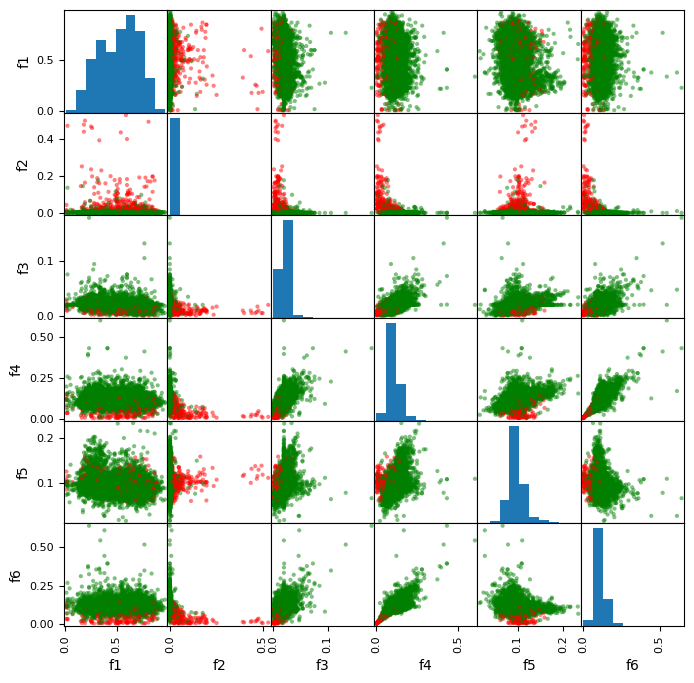

In [155]:
color_code = {'abnormal': 'r', 'normal': 'g'}

colors = df['result'].apply(lambda x: color_code[x])

pd.plotting.scatter_matrix(df, c=colors, figsize=(8, 8))
plt.show()

<font size="+1" color="red">Replace this cell with a brief commentary on whether you already guess any difference between normal and abnormal exams, based on combinations of features. What are the differences you can appreciate?</font>

From what we can see in the above plot, abnormal thyroid seems to be very correlated with values of `f2` that are not extremely close to 0, and values of `f6` that are extremely close to 0. 

# 1. Create isolation tree

## 1.1. Random dimension and random split

<font size="+1" color="red">Replace this cell with code implementing "pick_random_dimension" and a couple of calls to this function.</font>

In [122]:
def pick_random_dimension(df: pd.DataFrame, columns_to_ignore: list) -> str:
    cols = set(df.columns.to_list()) - set(columns_to_ignore)
    return random.choice(list(cols))

In [123]:
pick_random_dimension(df, ['result'])

'f3'

In [124]:
pick_random_dimension(df, ['f' + str(i) for i in range(7)])

'result'

<font size="+1" color="red">Replace this cell with code implementing "pick_random_split" and a couple of calls to test this function; each call should return a random split point chosen uniformly at random between the minimum and the maximum value along a dimension.</font>

In [125]:
def pick_random_split(df: pd.DataFrame, dimension: str) -> float:
    return random.uniform(np.min(df[dimension]), np.max(df[dimension]))

In [126]:
pick_random_split(df, 'f1')

np.float64(0.7799919791880094)

In [127]:
pick_random_split(df, pick_random_dimension(df, ['result']))

np.float64(0.22641387017128056)

## 1.2. Implement split data into two

<font size="+1" color="red">Replace this cell with code implementing "split_dataset".</font>

In [128]:
def split_dataset(df: pd.DataFrame, dimension: str, split: float):
    return (df[df[dimension] <= split], df[df[dimension] > split])

<font size="+1" color="red">Replace this cell with code testing "split_dataset", i.e., select a dimension and a cut-off and split the dataset, then print the two pieces and check that it is working correctly. Also check that the sum of the sizes of the two pieces is the size of the original data.</font>

In [129]:
(left, right) = split_dataset(df, 'f1', 0.5)
display(left.head(20))
display(right.head(20))
print(f'Size of the sum: {left['f1'].count() + right['f1'].count()}')

,f1,f2,f3,f4,f5,f6,result
1,0.24,0.00025,0.0300,0.14300,0.133,0.10800,normal
2,0.47,0.00190,0.0240,0.10200,0.131,0.07800,normal
4,0.23,0.00025,0.0260,0.13900,0.090,0.15300,normal
7,0.48,0.00208,0.0200,0.08600,0.078,0.11000,normal
11,0.18,0.00010,0.0230,0.09800,0.085,0.11500,normal
13,0.49,0.00060,0.0230,0.11300,0.102,0.11100,normal
15,0.39,0.00010,0.0180,0.09000,0.071,0.12600,normal
16,0.39,0.00060,0.0200,0.11400,0.100,0.11400,normal
19,0.50,0.06100,0.0096,0.01300,0.116,0.01100,abnormal
28,0.27,0.00050,0.0130,0.10800,0.079,0.13700,normal


,f1,f2,f3,f4,f5,f6,result
0,0.73,0.00060,0.0150,0.12000,0.082,0.14600,normal
3,0.64,0.00090,0.0170,0.07700,0.090,0.08500,normal
5,0.69,0.00025,0.0160,0.08600,0.070,0.12300,normal
6,0.85,0.00025,0.0230,0.12800,0.104,0.12100,normal
8,0.67,0.00130,0.0240,0.08700,0.109,0.08000,normal
9,0.76,0.00010,0.0290,0.12400,0.128,0.09700,normal
10,0.62,0.01100,0.0080,0.07300,0.074,0.09800,abnormal
12,0.59,0.00080,0.0230,0.09400,0.099,0.09475,normal
14,0.53,0.00230,0.0200,0.06300,0.095,0.06600,normal
17,0.65,0.00160,0.0180,0.07800,0.092,0.08500,normal


Size of the sum: 7200


## 1.3. Create one isolation tree

In [130]:
# LEAVE AS-IS

dfi = df.copy()
dfi.insert(0, 'id', [("P%.4d" % x) for x in range(1, 1 + len(df))])
dfi

,id,f1,f2,f3,f4,f5,f6,result
0,P0001,0.73,0.00060,0.0150,0.120,0.082,0.1460,normal
1,P0002,0.24,0.00025,0.0300,0.143,0.133,0.1080,normal
2,P0003,0.47,0.00190,0.0240,0.102,0.131,0.0780,normal
3,P0004,0.64,0.00090,0.0170,0.077,0.090,0.0850,normal
4,P0005,0.23,0.00025,0.0260,0.139,0.090,0.1530,normal
...,...,...,...,...,...,...,...,...
7195,P7196,0.59,0.00250,0.0208,0.079,0.099,0.0800,normal
7196,P7197,0.51,0.10600,0.0060,0.005,0.089,0.0055,abnormal
7197,P7198,0.51,0.00076,0.0201,0.090,0.067,0.1340,normal
7198,P7199,0.35,0.00280,0.0201,0.090,0.089,0.1010,normal


<font size="+1" color="red">Replace this cell with you code implementing "isolation_tree".</font>

In [131]:
def isolation_tree(data, columns_to_ignore, min_items):
    if len(data) <= min_items:
        return {"contents": data}
    else:
        rand_dim = pick_random_dimension(data, columns_to_ignore)
        split = pick_random_split(data, rand_dim)
        left, right = split_dataset(data, rand_dim, split)
        return {
            "left": isolation_tree(left, columns_to_ignore, min_items),
            "right": isolation_tree(right, columns_to_ignore, min_items),
            "dimension": rand_dim,
            "split": split,
        }

In [132]:
# LEAVE AS-IS

mytree = isolation_tree(dfi, ['id', 'result'], 2000)

In [133]:
# LEAVE AS-IS


class tree_drawing(object):
    def __init__(self, value, left=None, right=None):
        self.value = value
        self.left = left
        self.right = right

    def __str__(self, label='', level=0):
        ret = "-" * level + label + ":" + repr(self.value) + "\n"
        if self.left:
            ret += self.left.__str__("<", level + 1)
        if self.right:
            ret += self.right.__str__(">", level + 1)
        return ret

    def __repr__(self):
        return self.value


def tree_to_nodes(tree):
    if 'contents' in tree:
        data = tree['contents']
        normal_count = len(data[data['result'] == 'normal'])
        abnormal_count = len(data[data['result'] == 'abnormal'])
        description = "external node: %d normal + %d abnormal" % (
            normal_count,
            abnormal_count,
        )
        return tree_drawing(description)
    else:
        left = tree['left']
        right = tree['right']
        description = (
            'internal node: ' + tree['dimension'] + ' <= ' + ("%.2f" % tree['split'])
        )
        n = tree_drawing(description, tree_to_nodes(left), tree_to_nodes(right))
        return n

In [134]:
print(tree_to_nodes(mytree))

:'internal node: f1 <= 0.22'
-<:'external node: 392 normal + 31 abnormal'
->:'internal node: f5 <= 0.02'
--<:'external node: 2 normal + 0 abnormal'
-->:'internal node: f2 <= 0.24'
---<:'internal node: f5 <= 0.03'
----<:'external node: 5 normal + 0 abnormal'
---->:'internal node: f6 <= 0.47'
-----<:'internal node: f2 <= 0.03'
------<:'internal node: f2 <= 0.01'
-------<:'internal node: f5 <= 0.11'
--------<:'internal node: f3 <= 0.04'
---------<:'internal node: f5 <= 0.10'
----------<:'internal node: f1 <= 0.94'
-----------<:'internal node: f3 <= 0.02'
------------<:'external node: 1120 normal + 80 abnormal'
------------>:'internal node: f5 <= 0.07'
-------------<:'external node: 115 normal + 2 abnormal'
------------->:'internal node: f6 <= 0.24'
--------------<:'internal node: f6 <= 0.12'
---------------<:'internal node: f2 <= 0.01'
----------------<:'internal node: f5 <= 0.08'
-----------------<:'external node: 115 normal + 2 abnormal'
----------------->:'internal node: f1 <= 0.90'
--

<font size="+1" color="red">Replace this cell with you code implementing `get_max_tree_depth`</font>

In [135]:
def get_max_tree_depth(tree, depth=0):
    if 'contents' in tree:
        return depth
    return max(
        get_max_tree_depth(tree['left'], depth + 1),
        get_max_tree_depth(tree['right'], depth + 1),
    )

<font size="+1" color="red">Replace this cell with you code testing `get_max_tree_depth` on `mytree`.</font>

In [136]:
get_max_tree_depth(mytree)

20

# 2. Create isolation forests and find depth of items

## 2.1. Create an isolation forest

<font size="+1" color="red">Replace this cell with you code implementing "isolation_forest".</font>

In [137]:
def isolation_forest(
    dfi: pd.DataFrame, columns_to_ignore: list, min_items: int, num_trees: int
):
    return [isolation_tree(dfi, columns_to_ignore, min_items) for _ in range(num_trees)]

In [138]:
# MODIFY IF YOU SEE THAT IT IMPROVES THE SEPARATION BETWEEN CLASSES

min_items = 120
num_trees = 30

In [139]:
# LEAVE AS-IS

myforest = isolation_forest(dfi, ['id', 'result'], min_items, num_trees)
print("The forest has %d trees" % len(myforest))

The forest has 30 trees


Now we print the first two trees of this forest.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [140]:
# LEAVE AS-IS

for i in range(0, 2):
    print("Tree number %d" % i)
    print(tree_to_nodes(myforest[i]))
    print()

Tree number 0
:'internal node: f4 <= 0.53'
-<:'internal node: f3 <= 0.18'
--<:'internal node: f2 <= 0.37'
---<:'internal node: f5 <= 0.02'
----<:'external node: 2 normal + 0 abnormal'
---->:'internal node: f4 <= 0.27'
-----<:'internal node: f5 <= 0.10'
------<:'internal node: f6 <= 0.36'
-------<:'internal node: f4 <= 0.09'
--------<:'internal node: f6 <= 0.03'
---------<:'external node: 3 normal + 15 abnormal'
--------->:'internal node: f3 <= 0.01'
----------<:'internal node: f5 <= 0.04'
-----------<:'external node: 3 normal + 0 abnormal'
----------->:'internal node: f4 <= 0.06'
------------<:'external node: 34 normal + 16 abnormal'
------------>:'external node: 78 normal + 11 abnormal'
---------->:'internal node: f6 <= 0.12'
-----------<:'internal node: f5 <= 0.08'
------------<:'internal node: f5 <= 0.06'
-------------<:'external node: 19 normal + 0 abnormal'
------------->:'internal node: f5 <= 0.08'
--------------<:'internal node: f3 <= 0.01'
---------------<:'external node: 55 no

## 2.2. Find the average depth of an item

In [141]:
# LEAVE AS-IS


def find_element_depth_aux(tree, column_name, column_value, depth):

    if 'contents' in tree:
        # We are in a leaf node

        data = tree['contents']
        matching = data[data[column_name] == column_value]
        if len(matching) == 0:
            return None
        elif len(matching) > 1:
            print("Error: multiple elements match your search criterion")
            return None
        else:
            return depth
    else:
        # We are in an internal node

        in_left = find_element_depth_aux(
            tree['left'], column_name, column_value, depth + 1
        )
        if in_left == None:
            in_right = find_element_depth_aux(
                tree['right'], column_name, column_value, depth + 1
            )
            return in_right
        else:
            return in_left


def find_element_depth(tree, column_name, column_value):
    return find_element_depth_aux(tree, column_name, column_value, 0)

In [142]:
# LEAVE AS-IS


def print_sample_depths(df, sample_size, tested_tree):

    for result in ['normal', 'abnormal']:
        print("Depths for %s items" % result)

        sample = list(df[df['result'] == result]['id'].sample(sample_size))

        max_depth = get_max_tree_depth(tested_tree)
        for random_id in sample:
            print(
                "- id=%s is at depth %d/%d"
                % (
                    random_id,
                    find_element_depth(tested_tree, "id", random_id),
                    max_depth,
                )
            )


print("On shallow tree, having maximum depth %d" % get_max_tree_depth(mytree))
print_sample_depths(dfi, 5, mytree)
print()

print(
    "On first tree of forest, having maximum depth %d" % get_max_tree_depth(myforest[0])
)
print_sample_depths(dfi, 5, myforest[0])
print()

On shallow tree, having maximum depth 20
Depths for normal items
- id=P6657 is at depth 15/20
- id=P2269 is at depth 1/20
- id=P3187 is at depth 20/20
- id=P5749 is at depth 10/20
- id=P0409 is at depth 20/20
Depths for abnormal items
- id=P1585 is at depth 12/20
- id=P2172 is at depth 6/20
- id=P5913 is at depth 6/20
- id=P3246 is at depth 1/20
- id=P3038 is at depth 8/20

On first tree of forest, having maximum depth 31
Depths for normal items
- id=P1896 is at depth 24/31
- id=P6223 is at depth 22/31
- id=P3874 is at depth 25/31
- id=P1162 is at depth 27/31
- id=P4081 is at depth 22/31
Depths for abnormal items
- id=P2147 is at depth 18/31
- id=P6947 is at depth 15/31
- id=P0965 is at depth 11/31
- id=P0795 is at depth 12/31
- id=P1791 is at depth 11/31



<font size="+1" color="red">Replace this cell with a brief commentary on these depths.</font>

By doing some testing, it seems that the trees that better separate the two classes are the ones that have not a very high min_items value (around 100-120 seems to have a consistent results). On the one hand, if min_items is smaller than 100 it seems that if the trees are too deep, most elements will be in the "shallow end", thus not being able to distinguish between classes. On the other hand, if min_items is too large (e.g.: 500-1000), the tree is too shallow and the two classes get assigned similar values. I would probably say that having deeper trees is better, however it depends also on the dataset. If we had a larger dataset we would probably get better results for deeper trees. At around 100-120 we seem to have a sweet spot in our case.

<font size="+1" color="red">Replace this cell with you code implementing "find_average_depth".</font>

In [143]:
def find_average_depth(forest: list, column_name: str, value: float):
    return np.array(
        [find_element_depth(tree, column_name, value) for tree in forest]
    ).mean()

In [144]:
# LEAVE AS-IS

for result in ['normal', 'abnormal']:
    print("Average depths for %s items" % result)

    sample = list(dfi[dfi['result'] == result]['id'].sample(5))

    for random_id in sample:
        print(
            "- id=%s is at average depth %.1f"
            % (random_id, find_average_depth(myforest, "id", random_id))
        )

    print()

Average depths for normal items
- id=P2371 is at average depth 22.2
- id=P0922 is at average depth 14.3
- id=P2066 is at average depth 20.5
- id=P5761 is at average depth 21.9
- id=P1489 is at average depth 20.1

Average depths for abnormal items
- id=P1501 is at average depth 9.6
- id=P2691 is at average depth 20.8
- id=P5004 is at average depth 19.2
- id=P0861 is at average depth 7.5
- id=P6574 is at average depth 20.1



<font size="+1" color="red">Replace this cell with a brief commentary indicating how would you make the "find_average_depth" function more efficient if you wanted to obtain the average depth of **all** elements. Be concise but be precise, providing pseudocode if you consider it clearer than a text explanation.</font>

With our current implementation, we are searching one sample at a time, and if we wanted to search all the N samples we should perform N independent binary searches, which does not make sense if we have to look at all the samples. A much simpler solution to this problem would be to simply iterate through the whole tree in one pass and to look at the depth of all elements at once. This way we would avoid a LOT of resources in the search step.

# 3. Find the average depth of a sample of normal and abnormal points

## 3.1. Determine average depths

In [145]:
# LEAVE AS-IS

abnormal_point_ids = list(dfi[dfi['result'] == 'abnormal']['id'].sample(30))
normal_point_ids = list(dfi[dfi['result'] == 'normal']['id'].sample(30))

print("Normal point sample ids   : %s" % normal_point_ids)
print("Abnormal point sample ids : %s" % abnormal_point_ids)

Normal point sample ids   : ['P5823', 'P1044', 'P3106', 'P3875', 'P3570', 'P6465', 'P4629', 'P6823', 'P0669', 'P6918', 'P2535', 'P5266', 'P4586', 'P2029', 'P6729', 'P6447', 'P1113', 'P6299', 'P2189', 'P1826', 'P0382', 'P2307', 'P2360', 'P0377', 'P6422', 'P3993', 'P6201', 'P4723', 'P1839', 'P6020']
Abnormal point sample ids : ['P2939', 'P6769', 'P4543', 'P7051', 'P5228', 'P6714', 'P5875', 'P6041', 'P3551', 'P5185', 'P6382', 'P3204', 'P7179', 'P6148', 'P5608', 'P3626', 'P3783', 'P1763', 'P5308', 'P2855', 'P3643', 'P6718', 'P1900', 'P0663', 'P2171', 'P3773', 'P1538', 'P5612', 'P3246', 'P1635']


In [146]:
# LEAVE AS-IS

normal_depths = []
print("Depths of items in the 'normal' sample:")
for i in normal_point_ids:
    depth = find_average_depth(myforest, 'id', i)
    normal_depths.append(depth)
    print(" element id=%s is at average depth %.2f" % (i, depth))
print()

Depths of items in the 'normal' sample:
 element id=P5823 is at average depth 22.47
 element id=P1044 is at average depth 23.93
 element id=P3106 is at average depth 19.20
 element id=P3875 is at average depth 13.57
 element id=P3570 is at average depth 9.63
 element id=P6465 is at average depth 18.57
 element id=P4629 is at average depth 19.33
 element id=P6823 is at average depth 26.37
 element id=P0669 is at average depth 21.33
 element id=P6918 is at average depth 21.60
 element id=P2535 is at average depth 21.63
 element id=P5266 is at average depth 20.30
 element id=P4586 is at average depth 12.23
 element id=P2029 is at average depth 14.40
 element id=P6729 is at average depth 25.07
 element id=P6447 is at average depth 8.03
 element id=P1113 is at average depth 9.93
 element id=P6299 is at average depth 24.93
 element id=P2189 is at average depth 10.80
 element id=P1826 is at average depth 21.80
 element id=P0382 is at average depth 19.53
 element id=P2307 is at average depth 1

In [147]:
# LEAVE AS-IS

abnormal_depths = []
print("Depths of items in the 'abnormal' sample:")
for i in abnormal_point_ids:
    depth = find_average_depth(myforest, 'id', i)
    abnormal_depths.append(depth)
    print(" element id=%s is at average depth %.2f" % (i, depth))
print()

Depths of items in the 'abnormal' sample:
 element id=P2939 is at average depth 18.20
 element id=P6769 is at average depth 10.87
 element id=P4543 is at average depth 14.67
 element id=P7051 is at average depth 12.87
 element id=P5228 is at average depth 21.57
 element id=P6714 is at average depth 13.47
 element id=P5875 is at average depth 11.93
 element id=P6041 is at average depth 6.73
 element id=P3551 is at average depth 8.67
 element id=P5185 is at average depth 18.80
 element id=P6382 is at average depth 8.40
 element id=P3204 is at average depth 18.57
 element id=P7179 is at average depth 12.60
 element id=P6148 is at average depth 12.30
 element id=P5608 is at average depth 16.27
 element id=P3626 is at average depth 8.83
 element id=P3783 is at average depth 9.73
 element id=P1763 is at average depth 11.90
 element id=P5308 is at average depth 20.23
 element id=P2855 is at average depth 19.00
 element id=P3643 is at average depth 14.97
 element id=P6718 is at average depth 1

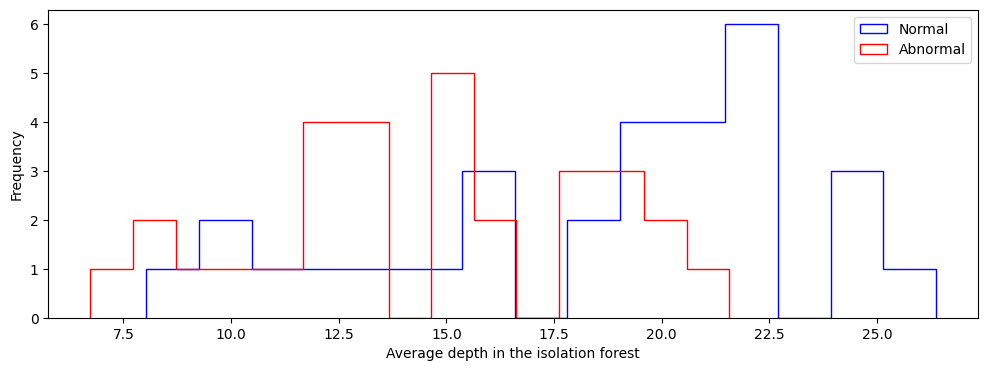

In [148]:
# LEAVE AS-IS

plt.figure(figsize=(12, 4))
plt.hist(
    normal_depths, label='Normal', bins=15, density=False, histtype='step', color='blue'
)
plt.hist(
    abnormal_depths,
    label='Abnormal',
    bins=15,
    density=False,
    histtype='step',
    color='red',
)
plt.xlabel('Average depth in the isolation forest')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<font size="+1" color="red">Replace this cell with a brief commentary of what you see in this histogram.</font>

We can see that the two classes are mostly separated, abnormal in the lower-end, and normal in the higher-end. However there is a considerable amount of datapoints that overlap in the depth range 13-19. If we find a datapoint that is contained in that range, we cannot really predict if it is normal or abnormal since the two classes are not completely separated using this analysis.

## 3.2. Compute outlier scores and conclude

In [149]:
# LEAVE AS-IS

# Source: https://stackoverflow.com/a/27683292/1235784

from numpy import euler_gamma
from scipy.special import digamma


def harmonic(s):
    return digamma(s + 1) + euler_gamma

In [150]:
# LEAVE AS-IS


def outlier_score_factory():
    n = len(df.index)
    c_n = 2.0 * harmonic(n - 1.0) - (2.0 * (n - 1) / n)
    return lambda d: 2.0 ** (-d / c_n)


outlier_score = outlier_score_factory()

normal_scores = [outlier_score(d) for d in normal_depths]
abnormal_scores = [outlier_score(d) for d in abnormal_depths]

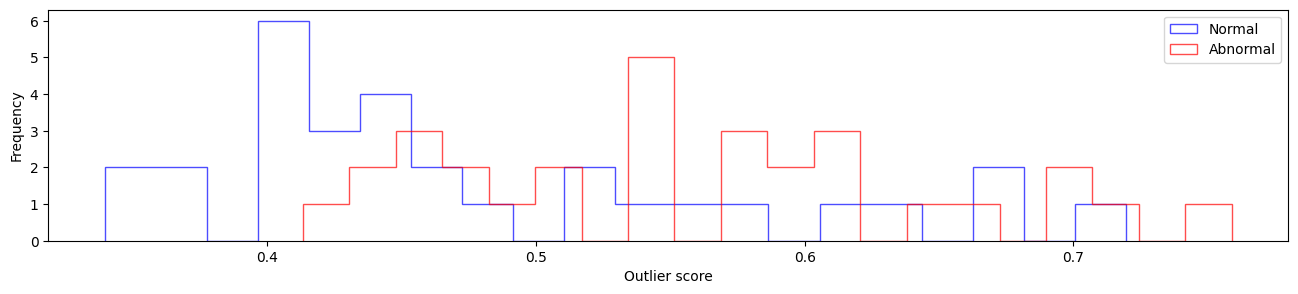

In [151]:
# LEAVE AS-IS

plt.figure(figsize=(16, 3))

# Plot the two histograms; the parameter 'alpha' is the transparency of the bar
plt.hist(
    normal_scores,
    label='Normal',
    bins=20,
    density=False,
    histtype='step',
    color='blue',
    alpha=0.7,
)
plt.hist(
    abnormal_scores,
    label='Abnormal',
    bins=20,
    density=False,
    histtype='step',
    color='red',
    alpha=0.7,
)

# Draw the axis labels, legend, and display
plt.xlabel('Outlier score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<font size="+1" color="red">Replace this cell with a brief commentary of what you see in this histogram.</font>

We can see in the above histogram that normal datapoints have low outlier score (smaller than 0.6), while abnormal datapoints have a relatively high outlier score (greater than 0.45). As before, we can also see that there is a range (0.45-0.6) that the two classes are overlapping, therefore deciding a threshold manually would be an error. We should be able to find a threshold using some kind of optimization technique to be able to maximize accuracy.

<font size="+1" color="red">Replace this cell with your code to determine an optimal threshold.</font>

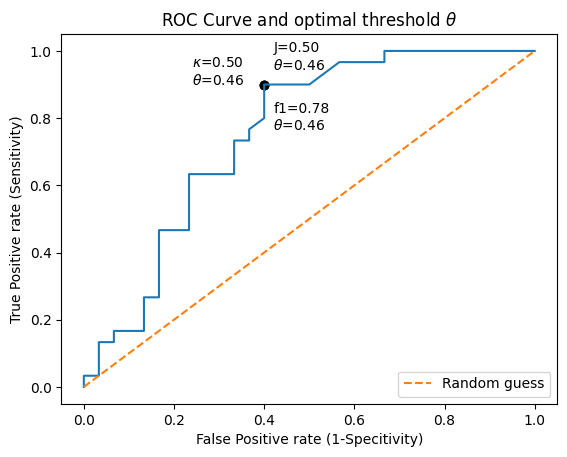

In [152]:
# Method 1: ROC curve
steps = 500
thresholds = np.linspace(0, 1, steps)

roc_stats = {
    'tp': np.zeros(steps),
    'tn': np.zeros(steps),
    'fp': np.zeros(steps),
    'fn': np.zeros(steps),
}

for i, thresh in enumerate(thresholds):
    roc_stats['tn'][i] = np.sum(normal_scores <= thresh)
    roc_stats['tp'][i] = np.sum(abnormal_scores > thresh)
    roc_stats['fn'][i] = np.sum(abnormal_scores <= thresh)
    roc_stats['fp'][i] = np.sum(normal_scores > thresh)

# Compute rates
tpr = roc_stats['tp'] / (roc_stats['tp'] + roc_stats['fn'])
# fnr = roc_stats['fn']/(roc_stats['tp']+roc_stats['fn'])
fpr = roc_stats['fp'] / (roc_stats['tn'] + roc_stats['fp'])
tnr = roc_stats['tn'] / (roc_stats['tn'] + roc_stats['fp'])

# Compute Youden's J statistic
# https://en.wikipedia.org/wiki/Youden%27s_J_statistic
J_stat = tpr + tnr - 1
J_max_idx = np.argmax(J_stat)
J_thresh = thresholds[J_max_idx]

# Compute F1-score
# https://en.wikipedia.org/wiki/F-score
f1 = 2 * roc_stats['tp'] / (2 * roc_stats['tp'] + roc_stats['fp'] + roc_stats['fn'])
f1_max_idx = np.argmax(f1)
f1_thresh = thresholds[f1_max_idx]

# Compute Cohen's kappa
# https://en.wikipedia.org/wiki/Cohen%27s_kappa#Binary_classification_confusion_matrix
kappa = (
    2
    * (roc_stats['tp'] * roc_stats['tn'] - roc_stats['fn'] * roc_stats['fp'])
    / (
        (roc_stats['tp'] + roc_stats['fp']) * (roc_stats['fp'] + roc_stats['tn'])
        + (roc_stats['tp'] + roc_stats['fn']) * (roc_stats['fn'] + roc_stats['tn'])
    )
)
kappa_max_idx = np.argmax(kappa)
kappa_thresh = thresholds[kappa_max_idx]

# Plot everything
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], label='Random guess', linestyle='dashed')

plt.scatter(fpr[J_max_idx], tpr[J_max_idx], c='k')
plt.annotate(
    f'J={J_stat[J_max_idx]:.2f}\n$\\theta$={J_thresh:.2f}',
    np.array([fpr[J_max_idx], tpr[J_max_idx]]) * 1.05,
)

plt.scatter(fpr[f1_max_idx], tpr[f1_max_idx], c='k')
plt.annotate(
    f'f1={f1[f1_max_idx]:.2f}\n$\\theta$={f1_thresh:.2f}',
    np.array([fpr[f1_max_idx] * 1.05, tpr[f1_max_idx] * 0.85]),
)

plt.scatter(fpr[kappa_max_idx], tpr[kappa_max_idx], c='k')
plt.annotate(
    f'$\\kappa$={kappa[kappa_max_idx]:.2f}\n$\\theta$={kappa_thresh:.2f}',
    np.array([fpr[kappa_max_idx] * 0.6, tpr[kappa_max_idx]]),
)

plt.xlabel('False Positive rate (1-Specitivity)')
plt.ylabel('True Positive rate (Sensitivity)')
plt.title('ROC Curve and optimal threshold $\\theta$')
plt.legend()
plt.show()

To compute the optimal threshold $\theta$ we have computed the optimal F1-score, Youden's J statistic and Cohen's kappa. All of them have the same result in our testing: $\theta = 0.46$. We have visualized our results using a ROC curve plot. With all the statistics computed we can safely say that this value for the threshold is optimal and moderately good in this dataset.

<font size="+1" color="red">Replace this cell with your evaluation of the optimal threshold.</font>

In [ ]:
optimal_thresh_idx = round(
    np.mean([J_max_idx, f1_max_idx, kappa_max_idx])
)  # not really needed but just in case they are different
print(f'tpr = {tpr[optimal_thresh_idx]:.2f}')
print(f'fpr = {fpr[optimal_thresh_idx]:.2f}')

tpr = 0.90
fpr = 0.40


<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>